In [1]:
from netCDF4 import Dataset, num2date
#we could otherwise import the whole netCDF4 instead that specific functions. 
#if so, to call specific func we type ex netCDF4.num2datea

In [34]:
#now we use the package to open the file and extract the data from the file
#for visualisation is better to use another package
#our file has 4 variables: latitude, longitude, time, temperature(air) 
#for each time, lat and long...it has the value of temperature
import pandas as pd
import geopandas as gpd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
from matplotlib.colors import ListedColormap

In [3]:
# Make larger figures by default
plt.rcParams['figure.figsize'] = [10, 5]

In [4]:
# Basemap for maps
from mpl_toolkits.basemap import Basemap

In [51]:
# numpy for arrays and meshes
import numpy as np

In [52]:
# Import rasterio and geocube to rasterise
import rasterio as ras
from geocube.api.core import make_geocube
from geocube.rasterize import rasterize_points_griddata, rasterize_points_radial

In [7]:
#our dataset has 4 variables so it s a bit more messy to work with: the time! 
#so it is not a table but a cube
#now we open the file using netCDF4 and extract data
file = 'air.mon.mean.nc'
nc = Dataset(file, mode='r')

In [8]:
#we are now storing the values of each variable under the names (lat, lon, air, time)
#so: going to nc then to variables get the key lat and store all values into a variable we call lat
#the last one is a bit funky because its not a number nor a string but is a format called datetime.
#so we want to make sure that python understands we are talking about a date and not just a number (num2date)
# ':' means we want aaall the rows and not just one
lat = nc.variables['lat'][:]
lon = nc.variables['lon'][:]
air = nc.variables['air'][:]
time_var = nc.variables['time']
dtime = num2date(time_var[:], time_var.units)

In [9]:
# Make plot continuous
# air_cyclic, lon_cyclic = addcyclic(air[50,:,:], lon)
# lon_cyclic = addcyclic(lon)
# Shift the grid so lons go from -180 to 180 instead of 0 to 360.
# air_cyclic, lon_cyclic = shiftgrid(180., air_cyclic, lon_cyclic, start=False)

In [10]:
#since we have 3 dimensions we have to tell pandas that he is excepting a multiIndex
#the first variable names is just a list with the names of the things
#the second line we create a MultiIndex on time, lon and lat
#then we pass the values of air temp
names = ['time', 'lat','lon']
index = pd.MultiIndex.from_product([dtime, lat, lon], names=names)
df = pd.DataFrame ({'Air':air.flatten()}, index=index)

In [11]:
#what this is doing is we are getting rid of that pesky date time values 
#and creating a new column just with the year and another just with the month
year = [row.year for row in dtime]
month =[row.month for row in dtime]

In [12]:
#we are creating the pandas dataframe (the excell-like thing) but now with our new column year
#NB. here we have the option of adding a column for 'month' but my laptop goes KO so I didnt
names = ['year', 'lat', 'lon']
index = pd.MultiIndex.from_product([year, lat, lon], names=names)
df = pd.DataFrame({'Air': air.flatten()}, index=index).reset_index()

In [13]:
# map2019 = df[df.year == 2000]
# map2019
#print(map2019.to_string())

In [14]:
# Convert longitudes to WGS84
def convert_lons(l):
    if l > 180:
        return l - 360
    else:
        return l
df.lon = df.lon.transform(convert_lons)

In [15]:
# df.groupby(['lat','lon']).mean()
# df.groupby(['lon','lat','year']).mean()

# the idea is that what the user chooses goes inside the get_group. for example, the user wants to see year==2000
# then the script should run:
# df.groupby('year').get_group(year_chosen_by_user)

In [16]:
# We group by lon, lat, year and discard 2020
df = df.groupby(['lon','lat','year']).mean().reset_index()
df = df[df.year != 2020]

In [17]:
#Selecting Data for a Specific Location based on lat&Long 
#The coordinates need to be rounded based on the grid values (every 2.5°)
df_lisbon = df[(df.lat == 37.5)&(df.lon == -2.5)]
df_salvador = df[(df.lat == 12.5)&(df.lon == 322.5)]

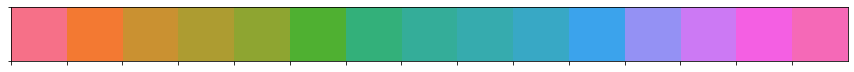

In [18]:
# How to make a palette (save it for later)
sns.palplot(sns.color_palette("husl", 15))

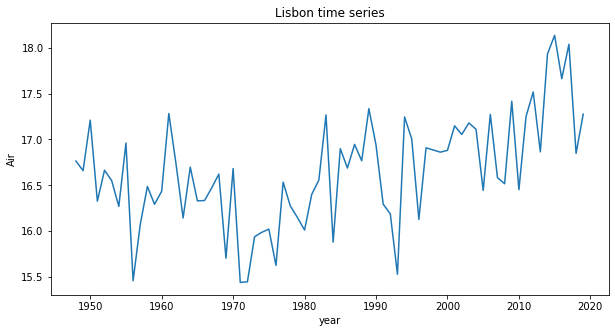

In [19]:
# Time series for Lisbon
sns.lineplot (x='year', y = 'Air', data = df_lisbon).set_title('Lisbon time series')
plt.show()

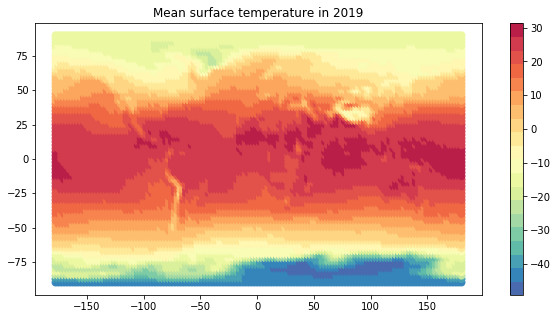

In [20]:
# We make a map for 2019
map2019 = df[df.year == 2019]

# In this one in fact we are cheating because it is a scatterplot, we need to transform to grid
# Prepare palette
cmap = ListedColormap(sns.color_palette("Spectral_r", 20))
f, ax = plt.subplots()
points = ax.scatter(map2019['lon'], map2019['lat'], c=map2019['Air'], s=50, cmap=cmap)
f.colorbar(points)
plt.title("Mean surface temperature in 2019")
plt.show()

In [72]:
# Let's convert the coordinates to geopandas point object
gmap2019 = gpd.GeoDataFrame(map2019, 
                            geometry=gpd.points_from_xy(map2019.lon, map2019.lat),
                            crs='+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs')
# We save the file for testing
gmap2019.to_file("pointstemp.shp")

In [85]:
# Next we rasterise with geocube
geo_grid = make_geocube(
    vector_data=gmap2019,
    measurements=['Air'],
    resolution=(2.51, -2.51))
# We save the file for testing
geo_grid.Air.rio.to_raster("data1.tif")